In [1]:
from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import error_analysis
from utils.analysis_tools_lazimpa import load_accuracies_lazimpa, load_entropies_by_setting

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('default')
import random
from seaborn.algorithms import bootstrap

# Quantitative analyses
This notebook contains code to plot and bootstrap confidence intervals for accuracies and other metrics for both context-unaware and context-aware trained agents.
Code defaults to context-aware, context-unaware results can be loaded by setting the context-unaware flag.

In [2]:
datasets = ('(3,4)', '(3,8)', '(4,4)')
n_attributes = (3, 3, 4)
n_values = (4, 8, 4)
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3/' for d in datasets]

In [46]:
datasets = ['(3,4)', ]
n_values = [4,]
n_attributes = [3, ]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [3]:
context_unaware = False # whether original or context_unaware simulations are evaluated
lazy = True # whether the lazy agent is used
impatient = True
setting = ""
if not lazy:
    start = 'impatience_' if impatient else ''
    if context_unaware:
        setting = start + 'context_unaware'
    else:
        setting = start + 'context_aware'
        if impatient == False:
            setting = 'standard'
else:
    start = 'lazimpa' if impatient else 'lazy'
    if context_unaware:
        setting = start + '_context_unaware'
    else:
        setting = start + '_context_aware'
setting

'lazimpa_context_aware'

## Accuracies

### Training trajectories

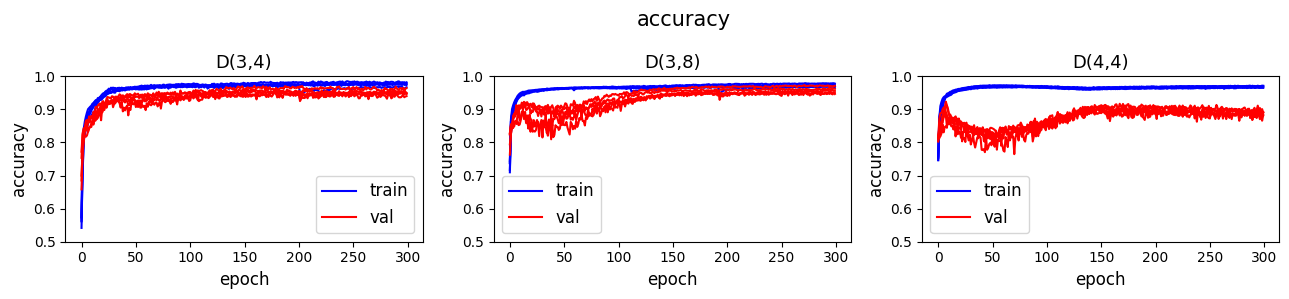

In [12]:
all_accuracies = load_accuracies_lazimpa(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=False,lazimpa=True)
plot_training_trajectory(all_accuracies['lazimpa_train_acc'], all_accuracies['lazimpa_val_acc'], ylim=(0.5, 1), steps=(1, 1), plot_shape=(1,3), titles=('D(3,4)', 'D(3,8)', 'D(4,4)'),figsize=(13, 3),plot_indices=(1,2,3))

### Learning speed

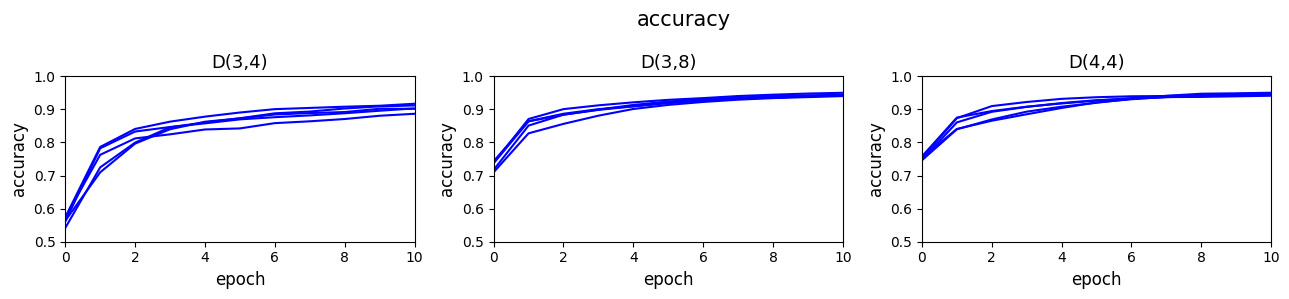

In [13]:
all_accuracies = load_accuracies_lazimpa(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=False,lazimpa=True)
plot_training_trajectory(all_accuracies['lazimpa_train_acc'], all_accuracies['lazimpa_val_acc'], ylim=(0.5, 1), xlim=(0, 10), steps=(1, 1), train_only=True, plot_shape=(1,3), titles=('D(3,4)', 'D(3,8)', 'D(4,4)'),figsize=(13, 3),plot_indices=(1,2,3)) 

### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [5]:
all_accuracies = load_accuracies_lazimpa(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=False,lazimpa=True)
accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc'],
              all_accuracies['lazimpa_train_acc'], all_accuracies['lazimpa_val_acc']]
test_accuracies = [all_accuracies['test_acc'], all_accuracies['lazimpa_test_acc']]

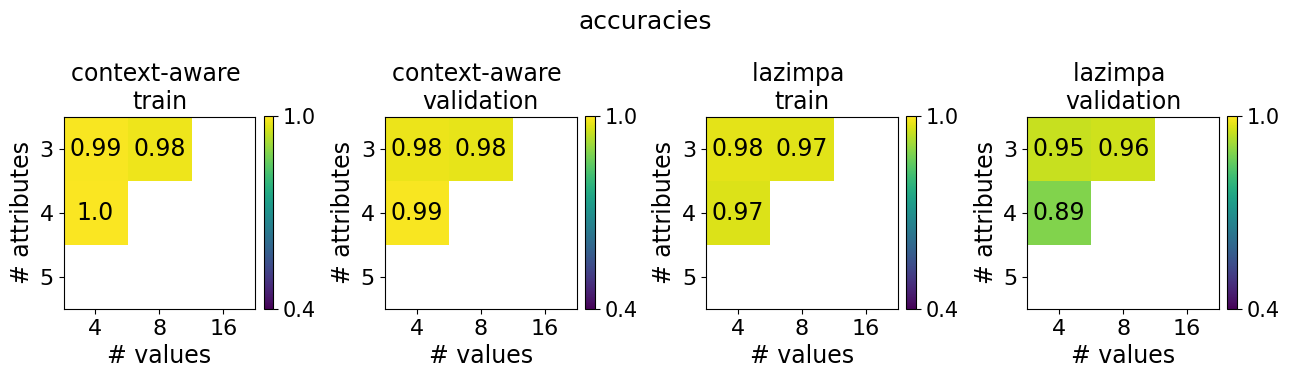

In [17]:

plot_heatmap(accuracies, 'mean', plot_dims=(1,4), ylims=(0.4, 1.0), figsize=(13, 3.5), suptitle='accuracies', 
             fontsize=17, matrix_indices=((0,0), (0,1), (1,0)), titles=('context-aware \ntrain', 'context-aware \nvalidation', 'lazimpa \ntrain', 'lazimpa \nvalidation'))

#### LazImpa

In [9]:
# training
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['lazimpa_train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.976, 0.005), '(3,8)': (0.972, 0.004), '(4,4)': (0.969, 0.002)}

In [10]:
# context unaware
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['lazimpa_val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.95, 0.008), '(3,8)': (0.957, 0.009), '(4,4)': (0.887, 0.004)}

#### Context-aware

In [11]:

final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.993, 0.003), '(3,8)': (0.984, 0.006), '(4,4)': (0.995, 0.003)}

In [12]:
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.983, 0.004), '(3,8)': (0.977, 0.006), '(4,4)': (0.993, 0.005)}

#### Accuracies: Boostrapped CIs

In [6]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

# context-aware (train, val), lazimpa (train, val)
for i in range(len(accuracies)):
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(accuracies[i]) for _ in range(len(accuracies[i]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({lower_percentile}, {upper_percentile}), Mean: {np.mean(bootstrap_means)}")

Bootstrap Confidence Interval (95.0%): (0.9738715597391129, 0.9845829124053319), Mean: 0.9785301127387418
Bootstrap Confidence Interval (95.0%): (0.9631263401110967, 0.9821836848788791), Mean: 0.9737742642664644
Bootstrap Confidence Interval (95.0%): (0.9631263401110967, 0.9821836848788791), Mean: 0.9706601558519293
Bootstrap Confidence Interval (95.0%): (0.8931968725654814, 0.9821836848788791), Mean: 0.9568266812293827


### Test accuracies
means and stds

In [15]:
test_accuracies


[array([[0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135],
        [0.63679951, 0.78210992, 0.73057991, 0.66146594, 0.61986005],
        [0.86967105, 0.97659606, 0.90132159, 0.98230481, 0.98235208]]),
 array([[0.75921154, 0.804317  , 0.75239319, 0.81156331, 0.80687499],
        [0.68995762, 0.70863867, 0.6653561 , 0.66140258, 0.71734947],
        [0.84349382, 0.87468827, 0.83738703, 0.83078647, 0.87515491]])]

In [16]:
# first context-aware, then lazimpa
for cond in test_accuracies:
    for i, d in enumerate(datasets):
        print(d, round(np.mean(cond[i]), 3), round(np.std(cond[i]), 3), round(np.min(cond[i]), 2), round(np.max(cond[i]), 2))

(3,4) 0.784 0.035 0.73 0.83
(3,8) 0.686 0.061 0.62 0.78
(4,4) 0.942 0.048 0.87 0.98
(3,4) 0.787 0.026 0.75 0.81
(3,8) 0.689 0.022 0.66 0.72
(4,4) 0.852 0.019 0.83 0.88


## ZLA significance

In [9]:
# Mean
results_dict = {'mean_length':[],'mean_weighted_length':[],'p_ZLA':[]}

for path_idx, path in enumerate(paths):
    mean_length, mean_weighted_length, p_zla = [], [], []

    for run in range(n_runs):
        data = pickle.load(open(path + '/' + setting + '/' + str(run) + '/ZLA_significance.pkl', 'rb'))
        mean_length.append(data['mean_message_length'])
        mean_weighted_length.append(data['mean_weighted_message_length'])
        p_zla.append(data['p_zla'])

    results_dict['mean_length'].append(mean_length)
    results_dict['mean_weighted_length'].append(mean_weighted_length)
    results_dict['p_ZLA'].append(p_zla)

print(results_dict)

{'mean_length': [[tensor(3.), tensor(3.), tensor(3.), tensor(3.), tensor(3.)], [tensor(3.), tensor(3.), tensor(3.), tensor(3.), tensor(3.)], [tensor(4.), tensor(4.), tensor(4.), tensor(4.), tensor(4.)]], 'mean_weighted_length': [[tensor(3.), tensor(3.), tensor(3.), tensor(3.), tensor(3.)], [tensor(3.), tensor(3.), tensor(3.), tensor(3.), tensor(3.)], [tensor(4.), tensor(4.), tensor(4.), tensor(4.), tensor(4.)]], 'p_ZLA': [[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)], [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.)], [tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.)]]}


results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/0/interactions/train/epoch_300/interaction_gpu0
results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/1/interactions/train/epoch_300/interaction_gpu0
results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/2/interactions/train/epoch_300/interaction_gpu0
results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/3/interactions/train/epoch_300/interaction_gpu0
results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/4/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/0/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/1/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/2/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/3/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/4/intera

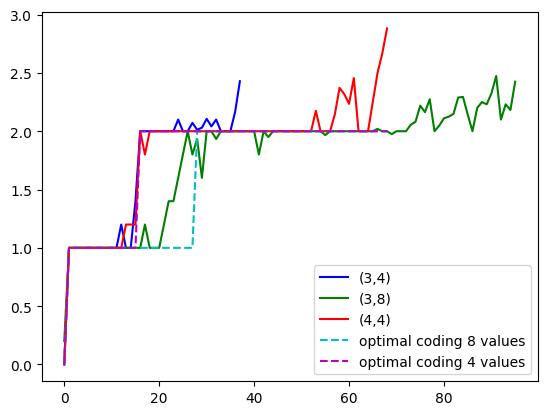

In [5]:
# plot frequency x mean
import torch
from utils.analysis_tools_lazimpa import load_interaction, retrieve_messages, optimal_coding
from language_analysis_local import MessageLengthHierarchical
import numpy as np

color = ['b', 'g', 'r', 'c', 'm']

for i,path in enumerate(paths):

    ordered_lengths_total = []

    for run in range(n_runs):
        messages = retrieve_messages(load_interaction(path,setting,run,n_epochs),as_list=False,remove_after_eos=True,eos_token=0.0)
        unique_messages, frequencies = torch.unique(messages,dim=0,return_counts=True)
        message_length = MessageLengthHierarchical.compute_message_length(unique_messages).tolist()
        frequencies = frequencies.tolist()

        max_frequency = max(frequencies)
        ordered_lengths = [list() for _ in range(max_frequency)]

        # list with frequency in index
        for f,l in zip(frequencies,message_length):
            ordered_lengths[f-1].append(l)

        # remove empty and sort by descending frequency
        ordered_lengths = [ sum(l)/len(l) for l in ordered_lengths if len(l) > 0]
        ordered_lengths.reverse()

        ordered_lengths_total.append(ordered_lengths)

    max_rank = max([len(ordered_lengths_total[i]) for i in range(len(ordered_lengths_total))])
    ordered_lengths_mean = []

    # calculate mean for each frequency rank
    for rank in range(max_rank):
        c = [ordered_lengths_total[run][rank] for run in range(n_runs) if len(ordered_lengths_total[run]) > rank]
        ordered_lengths_mean.append(sum(c) / len(c))

    plt.plot(list(range(max_rank)),ordered_lengths_mean,color[i],label=str(datasets[i]))

# optimal coding
for v,col in zip(set(n_values),color[-2:]):
    message_length_optimal = optimal_coding(vocab_size = (v + 1)*3, nr_messages=max_rank)
    plt.plot(list(range(len(message_length_optimal))),message_length_optimal,col,ls='--',label=f"optimal coding {str(v)} values")

plt.legend()

## Information analysis

#### LazImpa

In [38]:
results_dict = {'positional_encoding':[],'effective_length':[],'information_density':[]}

for path_idx, path in enumerate(paths):
    pe, el, id = [], [], []

    for run in range(n_runs):
        data = pickle.load(open(path + '/' + setting + '/' + str(run) + '/symbol_informativeness.pkl', 'rb'))
        pe.append(data['positional_encoding'])
        el.append(data['effective_length'])
        id.append(data['information_density'])

    results_dict['positional_encoding'].append(pe)
    results_dict['effective_length'].append(el)
    results_dict['information_density'].append(id)

# Average for each dataset
print("LazImpa")
print("Average Positional Encoding")
positional_encoding_array = [np.array([s2.tolist() for s2 in s]) for s in results_dict['positional_encoding']]
[print("D",d, np.nanmean(s,axis=0),np.nanstd(s,axis=0)) for s,d in  zip(positional_encoding_array,datasets)]

print("Average Effective length")
[print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['effective_length'],datasets)]
print("Average Information Density")
_ = [print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['information_density'],datasets)]

LazImpa
Average Positional Encoding
D (3,4) [0.96593064 0.94249694 0.88424243] [0.01031006 0.00742087 0.13128452]
D (3,8) [0.98531483 0.94340291 0.89413556] [0.00535769 0.00440128 0.03944149]
D (4,4) [0.92332428 0.93181075 0.88250537 1.        ] [0.00926543 0.00729703 0.05773334 0.        ]
Average Effective length
D (3,4) 1.0929554 0.077940576
D (3,8) 1.4283941 0.122321606
D (4,4) 1.010381 0.054123875
Average Information Density
D (3,4) 0.9602197 0.007441013
D (3,8) 0.9698178 0.0021576793
D (4,4) 0.9249541 0.008839039


#### Standard context-aware agent

In [37]:
results_dict = {'positional_encoding':[],'effective_length':[],'information_density':[]}

for path_idx, path in enumerate(paths):
    pe, el, id = [], [], []

    for run in range(n_runs):
        data = pickle.load(open(path + '/' + "standard"+ '/' + str(run) + '/symbol_informativeness.pkl', 'rb'))
        pe.append(data['positional_encoding'])
        el.append(data['effective_length'])
        id.append(data['information_density'])

    results_dict['positional_encoding'].append(pe)
    results_dict['effective_length'].append(el)
    results_dict['information_density'].append(id)

# Average for each dataset
print("Standard")
print("Average Positional Encoding")
positional_encoding_array = [np.array([s2.tolist() for s2 in s]) for s in results_dict['positional_encoding']]
[print("D",d, np.nanmean(s,axis=0),np.nanstd(s,axis=0)) for s,d in  zip(positional_encoding_array,datasets)]

print("Average Effective length")
[print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['effective_length'],datasets)]
print("Average Information Density")
_ = [print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['information_density'],datasets)]

Standard
Average Positional Encoding
D (3,4) [0.99364177 0.92578489 0.76721566] [0.00345413 0.02055855 0.05607563]
D (3,8) [0.99824997 0.97700716 0.90836023] [0.0009699  0.00230733 0.02559401]
D (4,4) [0.99833294 0.97344295 0.88653734 0.77437775] [0.00077346 0.00435653 0.01812606 0.02711257]
Average Effective length
D (3,4) 2.6866422 0.07305123
D (3,8) 2.8836174 0.027253835
D (4,4) 3.6326911 0.02967754
Average Information Density
D (3,4) 0.8955475 0.024350435
D (3,8) 0.9612058 0.009084612
D (4,4) 0.9081728 0.007419385


## Entropy scores

In [8]:
entropy_scores = load_entropies_by_setting(paths, setting = 'lazimpa_context_aware')
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

d:\Documents\GitHub\emergent-abstractions\utils\analysis_tools_lazimpa.py:586: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


### General

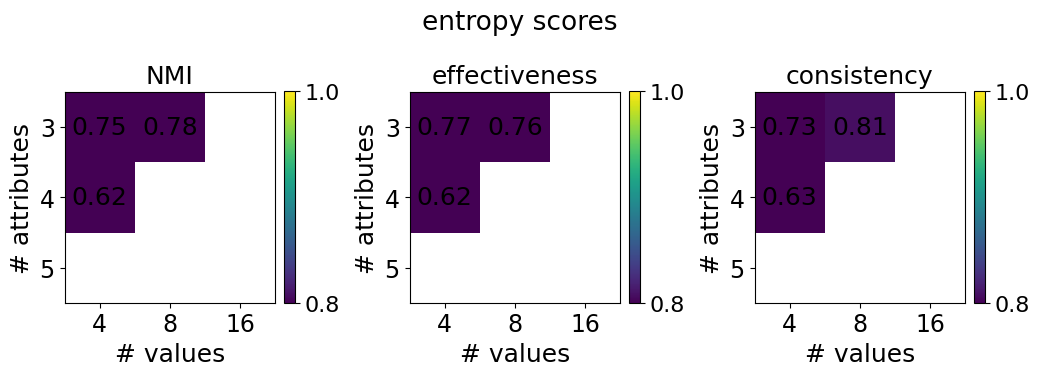

In [18]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.8, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='entropy scores',  matrix_indices=((0,0), (0,1), (1,0)))

#### Means and stds

In [19]:
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

{'(3,4)NMI': (0.75, 0.027),
 '(3,8)NMI': (0.783, 0.039),
 '(4,4)NMI': (0.624, 0.033),
 '(3,4)effectiveness': (0.77, 0.028),
 '(3,8)effectiveness': (0.76, 0.033),
 '(4,4)effectiveness': (0.621, 0.048),
 '(3,4)consistency': (0.731, 0.027),
 '(3,8)consistency': (0.807, 0.047),
 '(4,4)consistency': (0.629, 0.018)}

#### Bootstraped CIs

In [20]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for i in range(len(entropies)):
    score = list(entropy_scores.keys())[i]
    for idx, d in enumerate(datasets):
        for _ in range(num_bootstrap_samples):
            bootstrap_sample = [random.choice(entropies[i][idx]) for _ in range(len(entropies[i][idx]))]
            bootstrap_mean = np.mean(bootstrap_sample)
            bootstrap_means.append(bootstrap_mean)

        # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
        alpha = (1 - confidence_level) / 2
        lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
        upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
        #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
        entropies_bootstrapped[d + score] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
entropies_bootstrapped

{'(3,4)NMI': ((0.73, 0.77), 0.75),
 '(3,8)NMI': ((0.73, 0.81), 0.77),
 '(4,4)NMI': ((0.6, 0.81), 0.72),
 '(3,4)effectiveness': ((0.6, 0.8), 0.73),
 '(3,8)effectiveness': ((0.61, 0.8), 0.74),
 '(4,4)effectiveness': ((0.6, 0.8), 0.72),
 '(3,4)consistency': ((0.6, 0.8), 0.72),
 '(3,8)consistency': ((0.6, 0.83), 0.73),
 '(4,4)consistency': ((0.6, 0.83), 0.72)}

### Concept-dependent

In [21]:
# from generic to specific
entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[3:6]):
    results = entropies_hierarchical[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Bootstrapping CIs: Concept-level

#### Plotting Concept-level

In [22]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_hierarchical, 
                             'Effectiveness': effectiveness_hierarchical, 'Consistency': consistency_hierarchical}


In [23]:
all_hierarchical = {}
all_hierarchical['metric'] = ['Effectiveness'] * 150 + ['Consistency'] * 150 + ['NMI'] * 150 # change to 25 for one dataset
all_hierarchical['value'] = (entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'] +
                             entropy_dict_hierarchical['NMI'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

In [24]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]), scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Concept Level', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Concept (# Fixed Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

ValueError: All arrays must be of the same length

<Figure size 600x300 with 0 Axes>

##### one dataset only

In [28]:
all_hierarchical = {}
all_hierarchical['metric'] = ['NMI'] * 25 + ['Effectiveness'] * 25 + ['Consistency'] * 25 # change to 25 for one dataset
all_hierarchical['value'] = (entropy_dict_hierarchical['NMI'] + 
                             entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: Al

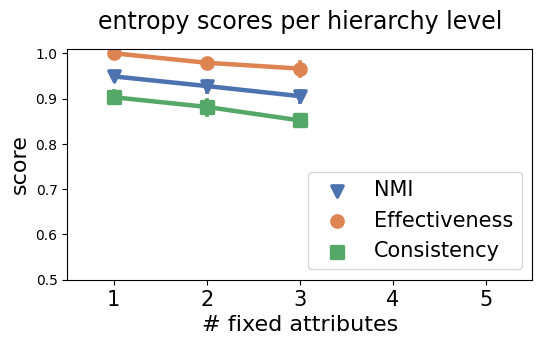

In [29]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', 
                   markers=['v', 'o', 's'], palette='deep', scale=1.2)
plt.ylabel('score', fontsize=16)
plt.title('entropy scores per hierarchy level', fontsize=17, y=1.05)
plt.ylim([0.5,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
#plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

#### Bootstrapping

In [15]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([1, 2, 3, 4, 5]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [16]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([1, 2, 3, 4, 5]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [17]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for level in [1, 2, 3, 4, 5]: 
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(data_for_bootstrapping[level]) for _ in range(len(data_for_bootstrapping[level]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
    entropies_bootstrapped[level] = (round(lower_percentile,3), round(upper_percentile,3)), round(np.mean(bootstrap_means),3)
entropies_bootstrapped
    

{1: ((0.9, 0.933), 0.917),
 2: ((0.903, 0.946), 0.928),
 3: ((0.904, 0.955), 0.934),
 4: ((0.906, 0.954), 0.936),
 5: ((0.907, 0.955), 0.938)}

### Context-dependent

In [18]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Bootstrapping CIs: Context

In [27]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([0, 1, 2, 3, 4]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_context_dep'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [41]:
setting = 'context_unaware'


In [42]:
# prepare data for bootstrapping
NMI_context_unaware = {}

for l, level in enumerate([0, 1, 2, 3, 4]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_context_dep'][l])
            except:
                pass
    #data_for_bootstrapping[level] = NMI_hierarchical
    if setting == 'standard':
        "hi"
        NMI_standard[level] = NMI_hierarchical
    else:
        NMI_context_unaware[level] = NMI_hierarchical


In [56]:
print(len(NMI_context_unaware[0]))
print(len(NMI_standard[0]))

30
30


In [69]:
from pingouin import ttest

ttest(NMI_context_unaware[0], NMI_standard[0], alternative='two-sided')


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.610556,58,two-sided,2.759296e-10,"[0.05, 0.08]",1.965037,2.62e+07,1.0


In [29]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for level in [0, 1, 2, 3, 4]: 
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(data_for_bootstrapping[level]) for _ in range(len(data_for_bootstrapping[level]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
    entropies_bootstrapped[level] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
entropies_bootstrapped
    

{0: ((0.87, 0.9), 0.88),
 1: ((0.87, 0.91), 0.89),
 2: ((0.87, 0.92), 0.9),
 3: ((0.87, 0.95), 0.91),
 4: ((0.88, 0.96), 0.92)}

#### Plotting per Context condition

In [30]:
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'Effectiveness': effectiveness_context_dep, 'Consistency': consistency_context_dep}


In [31]:
all_context_dep = {}
all_context_dep['metric'] = ['Effectiveness'] * 25 + ['Consistency'] * 25 +['NMI'] * 25 
all_context_dep['value'] = (entropy_dict_context_dep['Effectiveness'] + 
                             entropy_dict_context_dep['Consistency'] +
                             entropy_dict_context_dep['NMI']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: Al

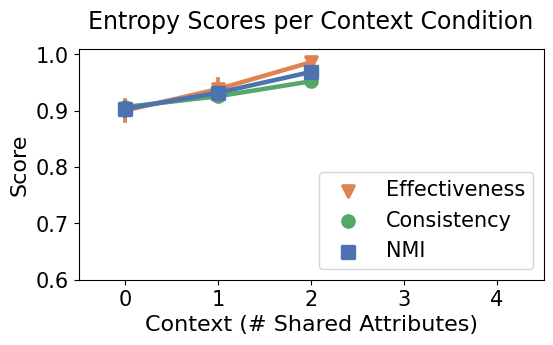

In [32]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]), 
                   scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Context Condition', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Context (# Shared Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

### Concept x Context

In [22]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])

#### NMI

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/plot_helpers.py:137: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


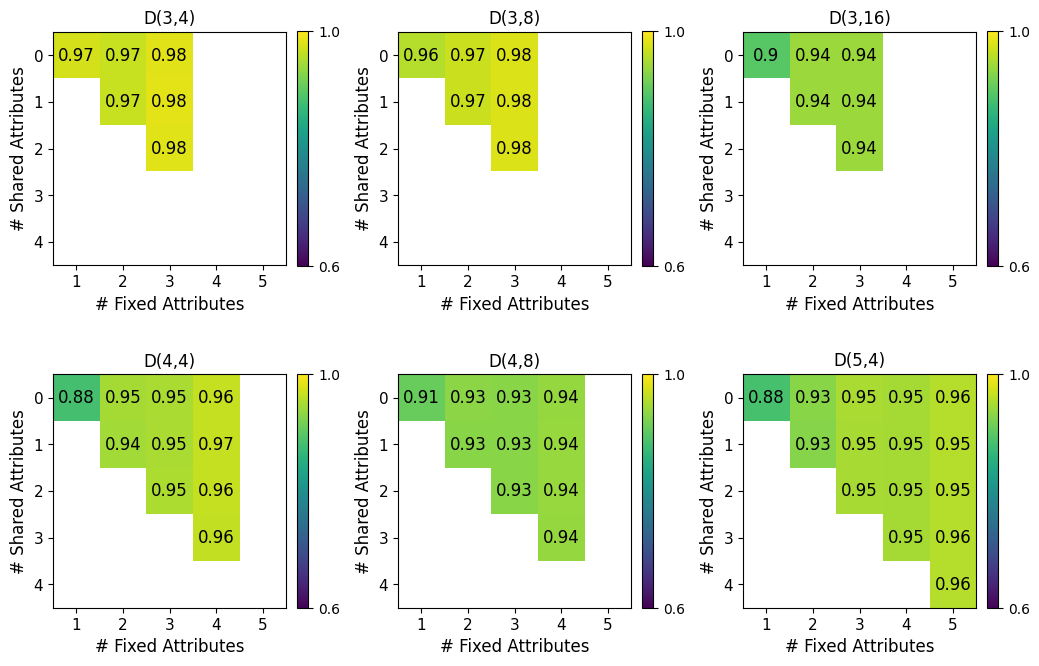

In [23]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

## Message length

In [38]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

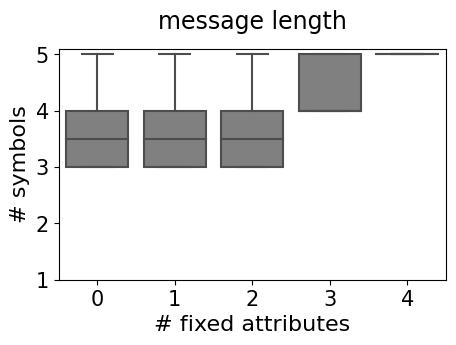

In [39]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, color='gray')
plt.xticks(fontsize=15)
plt.yticks(ticks=[1,2,3,4,5], labels=[1,2,3,4,5], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
plt.title('message length', fontsize=17, y=1.05)
plt.show()

## Symbol redundancy

In [40]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/symbol_redundancy.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)

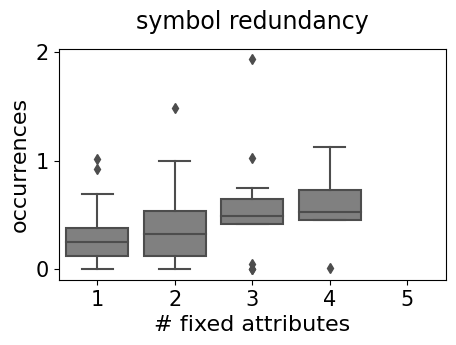

In [41]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(ticks=[0, 1, 2], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## Compositionality

In [42]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_generic, posdis_generic, bosdis_generic = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        posdis[d, run] = disent_score['posdis']
        bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        posdis_specific[d, run] = disent_score['posdis_specific']
        bosdis_specific[d, run] = disent_score['bosdis_specific']
        topsim_generic[d, run] = topsim_score['topsim_generic_train']
        posdis_generic[d, run] = disent_score['posdis_generic']
        bosdis_generic[d, run] = disent_score['bosdis_generic']

### Topsim

In [42]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))

(3,4) topsim: 0.46 sd 0.07
(3,8) topsim: 0.411 sd 0.06
(3,16) topsim: 0.287 sd 0.04
(4,4) topsim: 0.418 sd 0.04
(4,8) topsim: 0.336 sd 0.05
(5,4) topsim: 0.431 sd 0.06


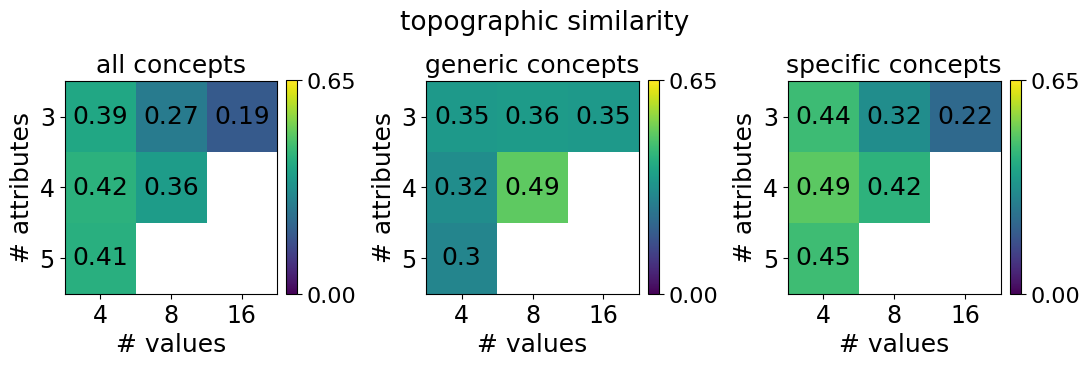

In [43]:
plot_heatmap([topsim, topsim_generic, topsim_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5), 
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='topographic similarity', suptitle_position=1.)

#### Topographic similarity over time

In [12]:
topsim_over_time = {}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/topsim_over_time.pkl', 'rb'))
            
        topsim_over_time[d][run] = scores
            
plt.plot(topsim_over_time[0][0])
round(max(topsim_over_time[0][0]) - min(topsim_over_time[0][0]), 3)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,4)_game_size_10_vsf_3/standard/0/topsim_over_time.pkl'

### Posdis

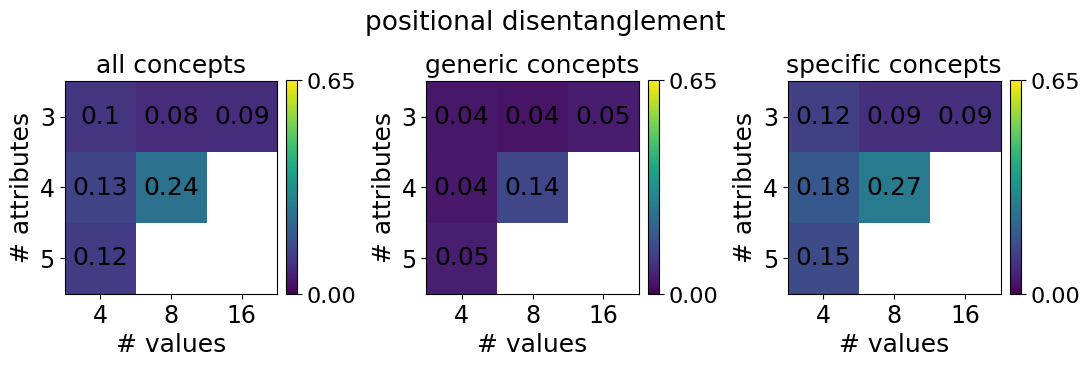

In [44]:
plot_heatmap([posdis, posdis_generic, posdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='positional disentanglement', suptitle_position=1.)

In [52]:
posdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(5):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_scores.pkl', 'rb')))
    posdis.append(sublist)

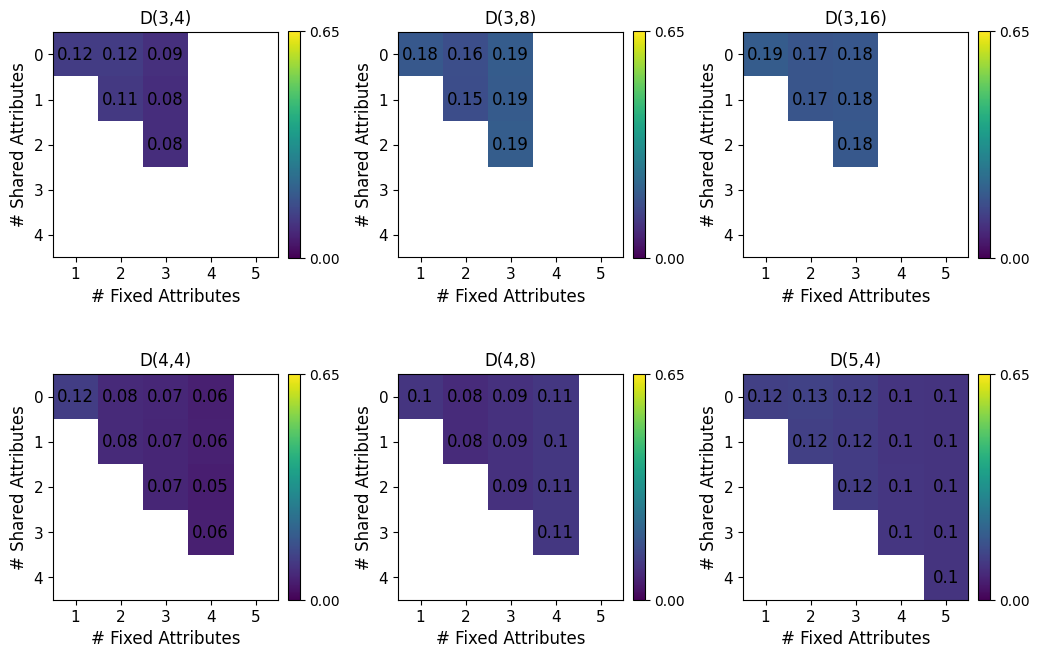

In [53]:
plot_heatmap_concept_x_context(posdis, score='posdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Bosdis

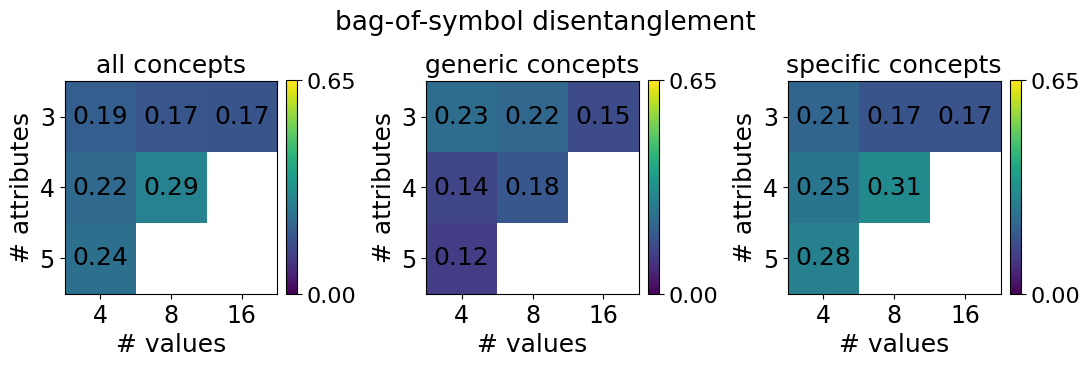

In [48]:
plot_heatmap([bosdis, bosdis_generic, bosdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [49]:
bosdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(5):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/bosdis_scores.pkl', 'rb')))
    bosdis.append(sublist)

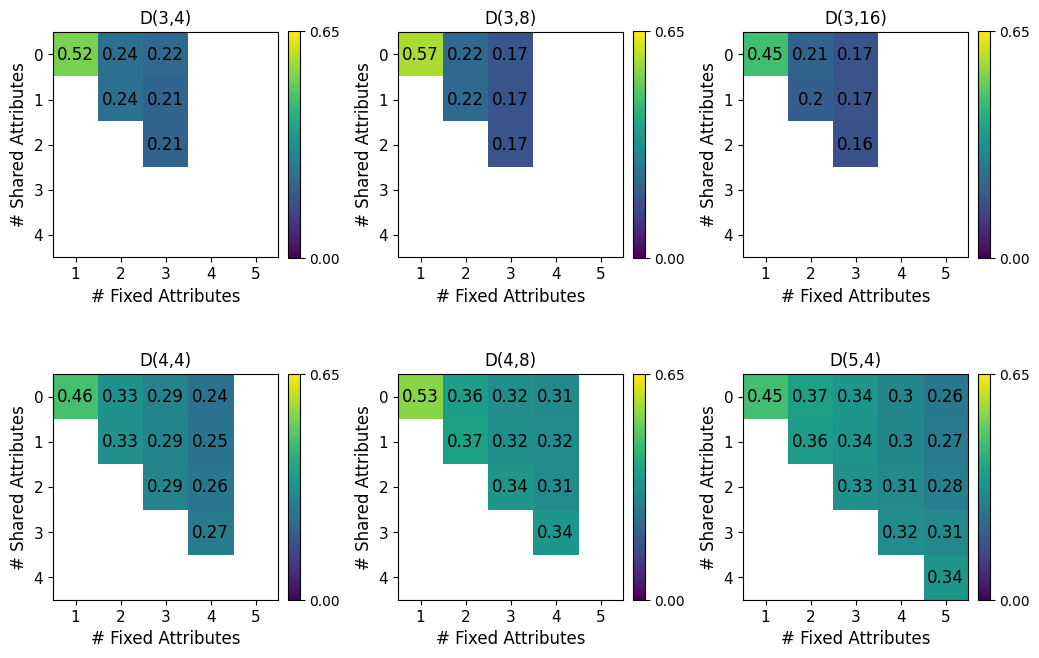

In [50]:
plot_heatmap_concept_x_context(bosdis, score='bosdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Compositionality per dataset

In [35]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

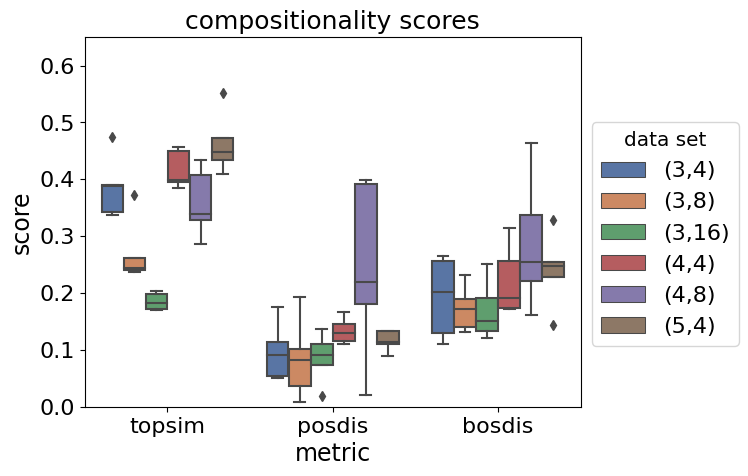

In [40]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

## Errors

In [200]:
validation = True # set to false if training interaction should be used
setting = 'standard'

In [57]:
import torch
from utils.analysis_from_interaction import *

In [201]:
def error_analysis(datasets, paths, setting, n_epochs, n_values, validation=True):
    """
    goes through interactions, retrieves concept and context conditions and counts errors, 
    i.e. incorrectly classified objects (by the receiver)
    """
    all_error_concepts = {}
    all_error_contexts = {}
    all_error_concept_x_context = {}
    all_false_positives = {}
    all_false_negatives = {}
    all_total_errs = {}

    all_acc_concept_x_context = {}

    all_total_concepts = {}
    all_total_contexts = {}
    all_total_concept_x_context = {}

    # go through all datasets
    for i, d in enumerate(datasets):
        print(i, d)
        error_concepts = {}
        error_contexts = {}
        error_concept_x_context = {}
        false_positives = {}
        false_negatives = {}
        total_errs = {}
        acc_concept_x_context = {}
        # select first run
        path_to_run = paths[i] + '/' + str(setting) + '/' + str(0) + '/'
        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        if validation:
            interaction = torch.load(path_to_interaction_val)
        else:
            interaction = torch.load(path_to_interaction_train)

        total_concepts = obtain_concept_counts(interaction.sender_input, n_values[i])

        total_contexts = obtain_context_counts(interaction.sender_input, n_values[i])

        total_concept_x_context = obtain_concept_x_context_counts(interaction.sender_input, n_values[i])

        for j in range(len(interaction.sender_input)):
            receiver_pred = (interaction.receiver_output[j][-1] > 0).float()  # use last symbol of message

            (objects, fixed) = get_fixed_vectors(interaction.sender_input, n_values[i], j)
            concept_str = str(int(sum(fixed[0])))

            context_conds = get_context_cond(interaction.sender_input, n_values[i], j, objects, fixed)
            context_str = str(context_conds[0])
            concept_x_context_str = (context_conds[0], int(sum(fixed[0]) - 1))
            
            # check if receiver has classified all objects correctly as targets or distractors
            if not torch.equal(receiver_pred, interaction.labels[j]):
                if concept_str in error_concepts:
                    error_concepts[concept_str] += 1
                else:
                    error_concepts[concept_str] = 1

                if context_str in error_contexts:
                    error_contexts[context_str] += 1
                else:
                    error_contexts[context_str] = 1

                if concept_x_context_str in error_concept_x_context:
                    error_concept_x_context[concept_x_context_str] += 1
                else:
                    error_concept_x_context[concept_x_context_str] = 1
                    
                # calculate false positives and false negatives
                num_false_pos = 0
                num_false_neg = 0
                errors = receiver_pred - interaction.labels[j]
                for error in errors:
                    # false positives
                    if error > 0:
                        num_false_pos += 1
                    # false negatives
                    elif error < 0:
                        num_false_neg += 1
                if concept_x_context_str in false_positives:
                    false_positives[concept_x_context_str] += num_false_pos
                else:
                    false_positives[concept_x_context_str] = num_false_pos
                if concept_x_context_str in false_negatives:
                    false_negatives[concept_x_context_str] += num_false_neg
                else:
                    false_negatives[concept_x_context_str] = num_false_neg
                if concept_x_context_str in total_errs:
                    total_errs[concept_x_context_str] += (num_false_pos + num_false_neg)
                else:
                    total_errs[concept_x_context_str] = (num_false_pos + num_false_neg)
                #print("per round", error_concept_x_context)
                #print("total", total_errs)

            # check if receiver has classified some objects correctly as targets or distractors
            # (this is how the accuracy is calculated during training)
            if concept_x_context_str in acc_concept_x_context:
                acc_concept_x_context[concept_x_context_str] += (
                    (receiver_pred == interaction.labels[j]).float().mean().numpy())
            else:
                acc_concept_x_context[concept_x_context_str] = (
                        receiver_pred == interaction.labels[j]).float().mean().numpy()
                
        #print(error_concept_x_context)
        #print("total errs", total_errs)
        #print("total cxc", total_concept_x_context)

        all_error_concepts[d] = error_concepts
        all_error_contexts[d] = error_contexts
        all_error_concept_x_context[d] = error_concept_x_context
        all_false_positives[d] = false_positives
        all_false_negatives[d] = false_negatives
        all_total_errs[d] = total_errs

        all_acc_concept_x_context[d] = acc_concept_x_context

        all_total_concepts[d] = total_concepts
        all_total_contexts[d] = total_contexts
        all_total_concept_x_context[d] = total_concept_x_context

    return (all_error_concepts, all_error_contexts, all_error_concept_x_context, 
            all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
            all_total_concepts, all_total_contexts, all_total_concept_x_context)

In [202]:
(all_error_concepts, all_error_contexts, all_error_concept_x_context, 
 all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
 all_total_concepts, all_total_contexts, all_total_concept_x_context) = error_analysis(datasets, paths, setting, n_epochs, n_values, validation)

0 (3,4)
1 (3,8)
2 (3,16)
3 (4,4)
4 (4,8)
5 (5,4)


In [101]:
err_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_error_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_error_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    err_ratio_concept_x_context[d] = ratio_concept_x_context

In [158]:
all_total_errs['(3,4)'] # how many objects were classified incorrectly per condition

{(2, 2): 92, (0, 1): 17, (1, 1): 60}

In [164]:
all_error_concept_x_context['(3,4)'] # how often data in a specific condition was classified incorrectly

{(2, 2): 34, (0, 1): 4, (1, 1): 16}

In [159]:
all_total_concept_x_context['(3,4)'] # how often the specific concept x context condition is present in the interaction

{(0, 2): 118, (2, 2): 144, (1, 2): 121, (1, 1): 101, (0, 1): 91, (0, 0): 21}

In [149]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    print(d)
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        print(concept_x_context)
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / #* (all_total_errs[d][concept_x_context] / 
            all_total_concept_x_context[d][concept_x_context], 4)
            #print(all_false_positives[d][concept_x_context] / all_total_errs[d][concept_x_context])
            print(all_total_errs[d][concept_x_context], all_total_concept_x_context[d][concept_x_context], all_total_errs[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
            print(all_false_positives[d][concept_x_context], all_false_positives[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

(3,4)
(0, 2)
(2, 2)
92 144 0.6388888888888888
92 0.6388888888888888
(1, 2)
(1, 1)
60 101 0.594059405940594
23 0.22772277227722773
(0, 1)
17 91 0.18681318681318682
0 0.0
(0, 0)
(3,8)
(1, 1)
190 402 0.472636815920398
40 0.09950248756218906
(0, 2)
1 1022 0.0009784735812133072
1 0.0009784735812133072
(2, 2)
370 1025 0.36097560975609755
370 0.36097560975609755
(1, 2)
12 986 0.012170385395537525
12 0.012170385395537525
(0, 1)
117 399 0.2932330827067669
0 0.0
(0, 0)
26 44 0.5909090909090909
0 0.0
(3,16)
(1, 2)
303 8253 0.036713922210105415
133 0.016115351993214587
(2, 2)
4144 8132 0.5095917363502214
3954 0.48622725036891296
(0, 1)
739 1562 0.4731113956466069
10 0.006402048655569782
(0, 2)
134 8168 0.016405484818805095
4 0.0004897159647404506
(1, 1)
1150 1561 0.7367072389493914
456 0.29212043561819345
(0, 0)
226 92 2.4565217391304346
11 0.11956521739130435
(4,4)
(1, 3)
(1, 2)
71 495 0.14343434343434344
0 0.0
(3, 3)
283 526 0.5380228136882129
283 0.5380228136882129
(1, 1)
56 188 0.2978723404255

In [203]:
false_objects_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_total_errs[d]:
            ratio_concept_x_context[concept_x_context] = round(all_total_errs[d][concept_x_context] / (all_total_concept_x_context[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_objects_ratio[d] = ratio_concept_x_context

In [194]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

In [195]:
false_negatives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_negatives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_negatives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_negatives_ratio[d] = ratio_concept_x_context

In [94]:
acc_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_acc_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_acc_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    acc_ratio_concept_x_context[d] = ratio_concept_x_context

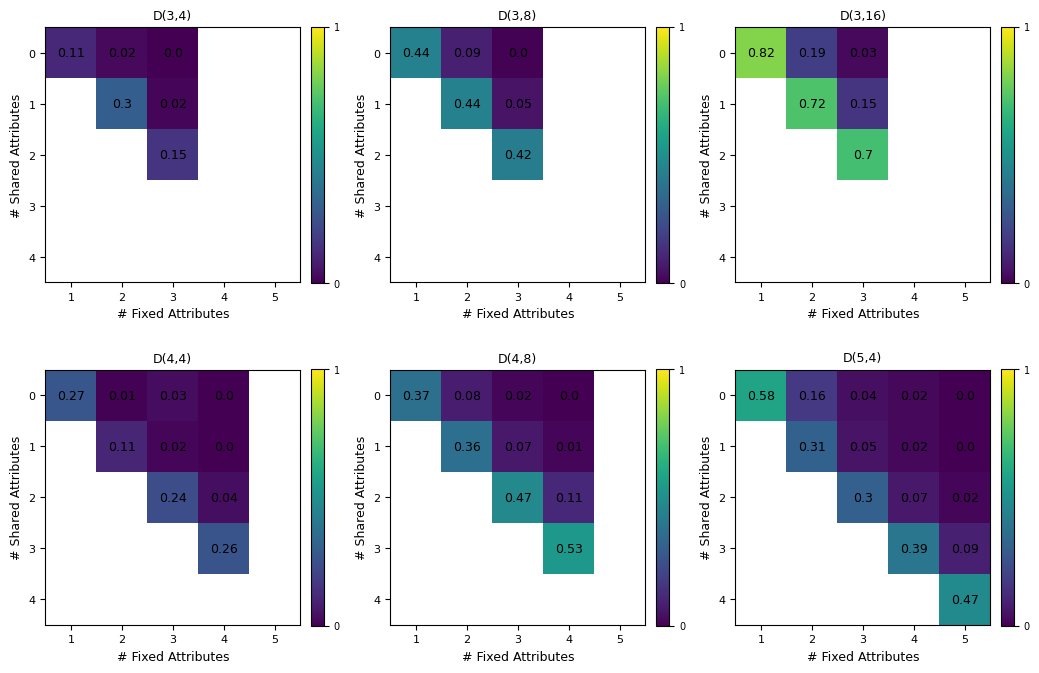

In [104]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

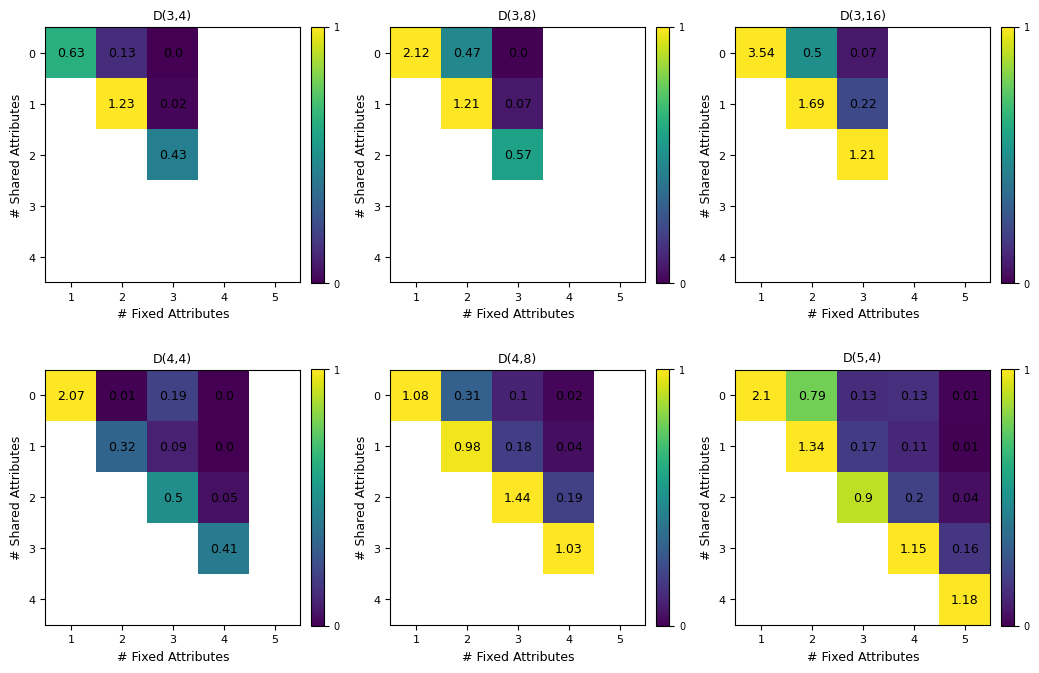

In [204]:
plot_heatmap_concept_x_context_errors(false_objects_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

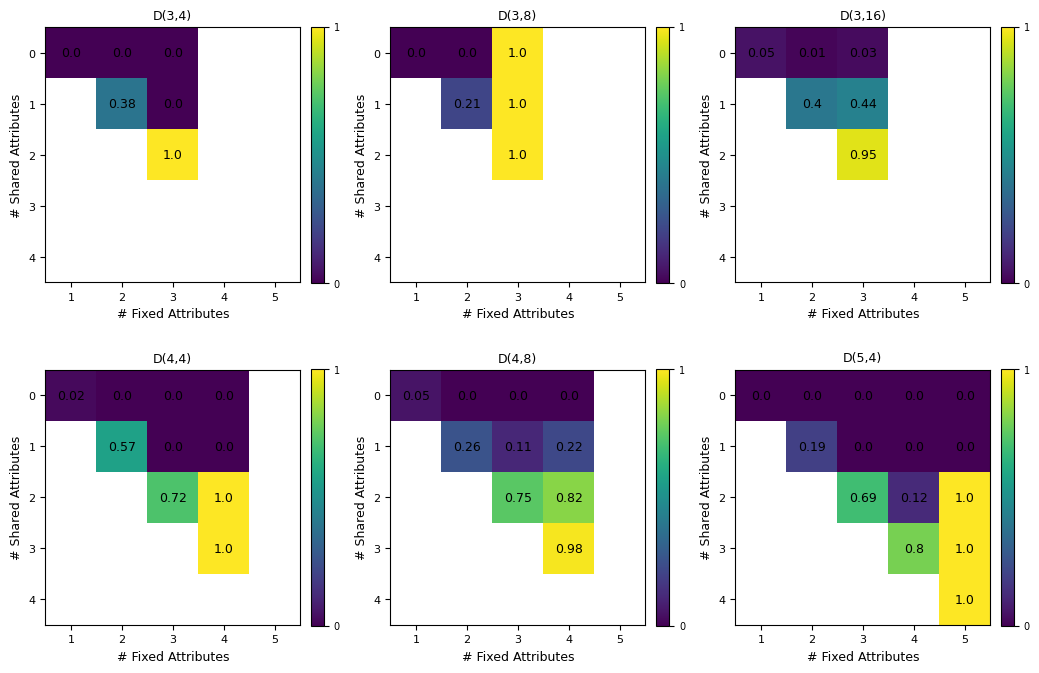

In [196]:
plot_heatmap_concept_x_context_errors(false_positives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

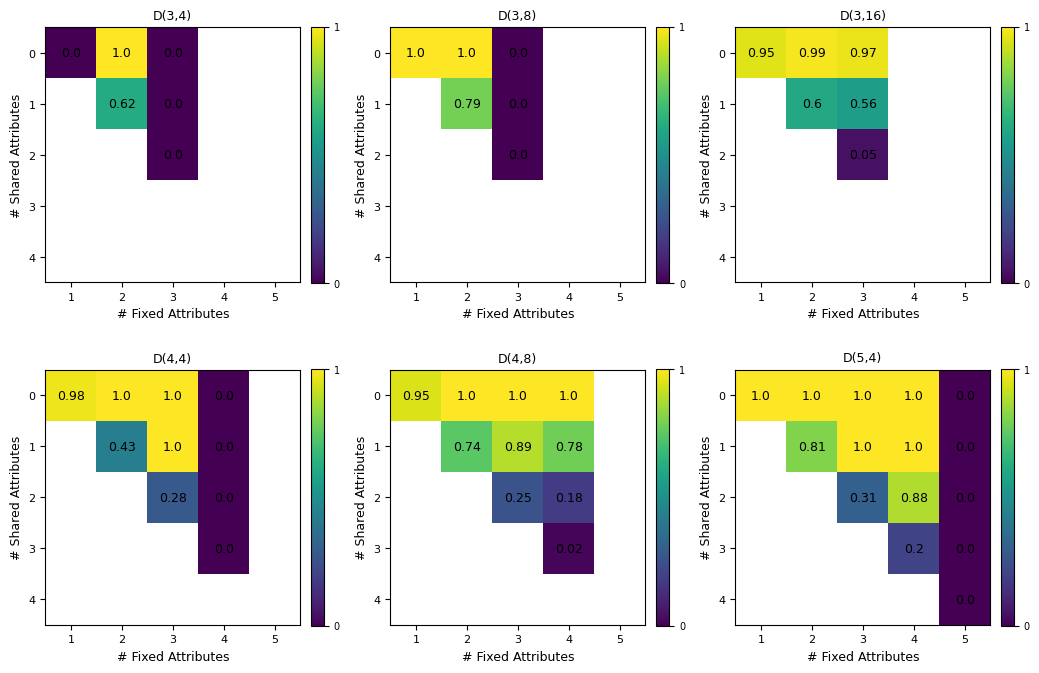

In [197]:
plot_heatmap_concept_x_context_errors(false_negatives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

In [210]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
# objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)] # 1.79
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0)] # 2.58
objects = [(2, 1, 0,), (2, 0, 1), (2, 2, 2), (1, 1, 1), (0, 1, 0), (1, 0, 0)] # 2.58

# 1. Bestimme die Häufigkeit jedes einzigartigen Objekts in der Liste
object_counts = Counter(objects)

# 2. Berechne die relative Häufigkeit jedes Objekts
total_objects = len(objects)
object_probabilities = {obj: count / total_objects for obj, count in object_counts.items()}

# 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
entropy = -sum(prob * np.log2(prob) for prob in object_probabilities.values())

# Ausgabe der berechneten Entropie
print("Die berechnete Entropie beträgt:", entropy)

Die berechnete Entropie beträgt: 2.584962500721156


In [206]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)]

# Transpose the list of objects to get attributes as columns
attributes = np.array(objects).T

# Initialize a list to store the entropy for each attribute
attribute_entropy = []

# Calculate entropy for each attribute
for attribute_values in attributes:
    # 1. Bestimme die Häufigkeit jedes einzigartigen Werts in der Liste
    attribute_counts = Counter(attribute_values)
    
    # 2. Berechne die relative Häufigkeit jedes Werts
    total_values = len(attribute_values)
    value_probabilities = {value: count / total_values for value, count in attribute_counts.items()}
    
    # 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
    entropy = -sum(prob * np.log2(prob) for prob in value_probabilities.values() if prob != 0)
    
    attribute_entropy.append(entropy)

# Ausgabe der berechneten Entropie für jedes Attribut
print("Die berechnete Entropie für jedes Attribut beträgt:", attribute_entropy)

Die berechnete Entropie für jedes Attribut beträgt: [0.6500224216483541, 0.6500224216483541, 0.6500224216483541]


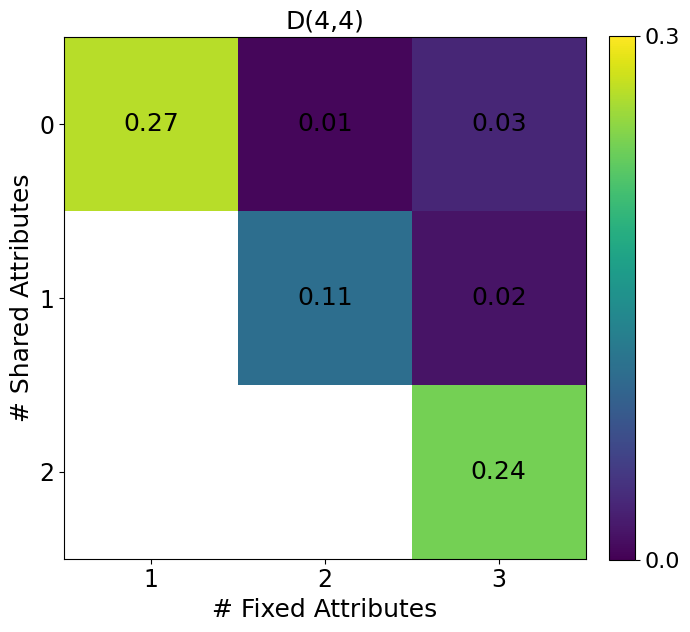

In [211]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context['(4,4)'], one_dataset=True, attributes=4, titles=('D(4,4)',), ylims=(0, 0.3), plot_dims=(1, 1))

## co-occurrences (not done yet)

In [ ]:
# Not done (yet)
full_plot = False

fig = plt.figure(figsize=(12,3))

for d, dim in enumerate(datasets): 
    
    data = datasets[d]
    path = paths[d]
    vs_factor = int(path[-2])
    vocab_size = (n_values[d] + 1) * vs_factor + 1
    colors = plt.cm.jet(np.linspace(0,1,vocab_size))
    
    average_cooccurences = []
    
    plt.subplot(1,6,d+1)
    
    for run in range(5):
        
        cooccurences = pickle.load(open(paths[d] + 'standard/' + str(run) + '/normalized_cooccurrence.pkl', 'rb'))
        indices = np.flip(np.argsort(cooccurences[:,-1]))
        cooccurences = cooccurences[indices]
        average_cooccurences.append(cooccurences)
        
    average_cooccurences = np.flip(np.mean(average_cooccurences, axis=0), axis=1)
    
    data_dict = {}
    data_dict['symbol rank'] = []
    data_dict['level'] = []
    data_dict['value'] = []
    for symbol in indices:
        for level in range(average_cooccurences.shape[1]):
            data_dict['symbol rank'].append(symbol+1)
            data_dict['level'].append(level)
            data_dict['value'].append(average_cooccurences[symbol, level])
    
    if full_plot:
        g = sns.heatmap(average_cooccurences, cmap='viridis')
        plt.yticks(ticks=[0.5,vocab_size-1.5], labels=[1,vocab_size], fontsize=14)
    else: 
        g = sns.heatmap(average_cooccurences[0:10,:], cmap='viridis')
        plt.yticks(ticks=[0.5,9.5], labels=[1,10], fontsize=14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=13)
    for _, spine in g.spines.items():
        spine.set_visible(True)
    #plt.xlabel('# relevant attributes', fontsize=14)
    #plt.ylabel('symbol rank', fontsize=14)
    plt.xticks(ticks=np.arange(n_attributes[d])+0.5, labels=range(1,n_attributes[d]+1), fontsize=14)
    plt.title(data, fontsize=14)
    
    fig.text(0.5, -0.05, '# relevant attributes', ha='center', va='center', fontsize=15, alpha=0.3)
    fig.text(-0.01, 0.5, 'symbol rank', ha='center', va='center', rotation='vertical', fontsize=15, alpha=0.3)

plt.tight_layout()